In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import packages
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model # type: ignore
import tensorflow as tf
import json

# Local imports
from src.data_processing.lstm_data_preprocessing_v3 import reduce_time_bucket_features, FeaturesConfig, TimeBucketConfig
from src.data_processing.loader import load_time_bucket_data

In [3]:
# Load the model and details on configurations used to train the model like the time bucket data used and the features used

# Custom loss function
def weighted_mse_large_moves(y_true, y_pred):
    diff = y_true - y_pred
    weight = tf.math.square(y_true)
    return tf.reduce_mean(weight * tf.square(diff))

model_folder = "../model_generation/trained_models/lstm_1"
model = load_model(os.path.join(model_folder, "model.keras"),
    custom_objects={'weighted_mse_large_moves': weighted_mse_large_moves})
with open(os.path.join(model_folder, "config.json"), 'r') as f:
    configs = json.load(f)

features_config = FeaturesConfig(**configs["features_config"])
time_bucket_folder = configs["time_bucket_folder"]
test_size = configs["test_size"]

In [4]:
# Get the train test data set used to train the model were testing

X_scaler = StandardScaler()
y_scaler = StandardScaler()

token_time_buckets, time_bucket_config = load_time_bucket_data(time_bucket_folder)

token_datasets = []
for token_address, data in token_time_buckets.items():
    X = data["X"]
    y = data["y"]
    bucket_times = data["bucket_times"]

    # Only get the features listed in features_config
    X = reduce_time_bucket_features(X, features_config)

    token_datasets.append((X, y, token_address, bucket_times))

# Combine all token data
all_X = np.vstack([data[0] for data in token_datasets])
all_y = np.vstack([data[1].reshape(-1, 1) for data in token_datasets])

# Scale features
num_samples, time_steps, features = all_X.shape
X_reshaped = all_X.reshape(num_samples * time_steps, features)
X_scaled = X_scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(num_samples, time_steps, features)

# Scale target variable also using StandardScaler to preserve direction
y_scaled = y_scaler.fit_transform(all_y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=test_size, shuffle=False)

In [5]:
y_pred = model.predict(X_test)

# Inverse transform to get real values
y_pred_actual = y_scaler.inverse_transform(y_pred)
y_test_actual = y_scaler.inverse_transform(y_test)

523/523 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step


In [ ]:
from visualisation_methods import plot_error_distribution, plot_directional_accuracy

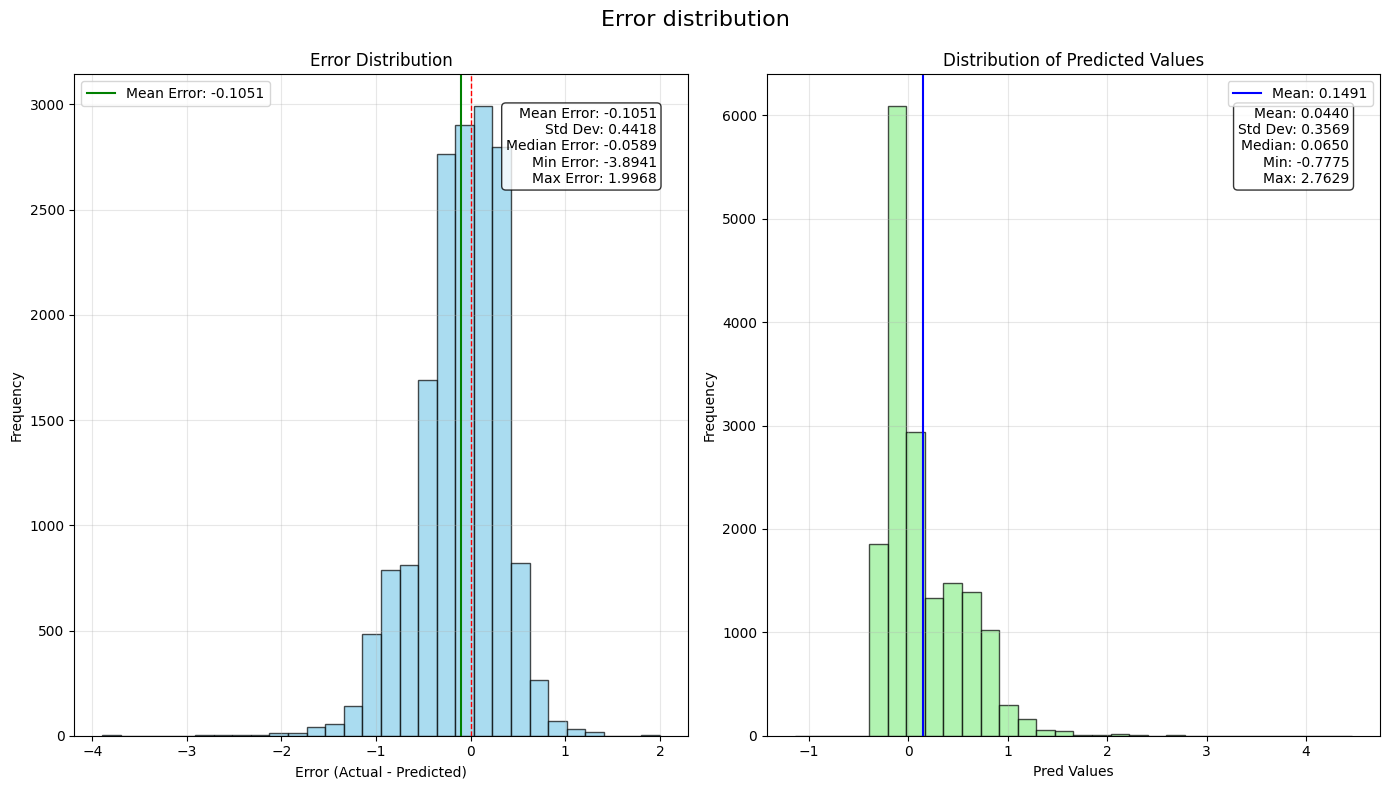

In [7]:
plot_error_distribution(y_pred_actual, y_test_actual, title="Error distribution")

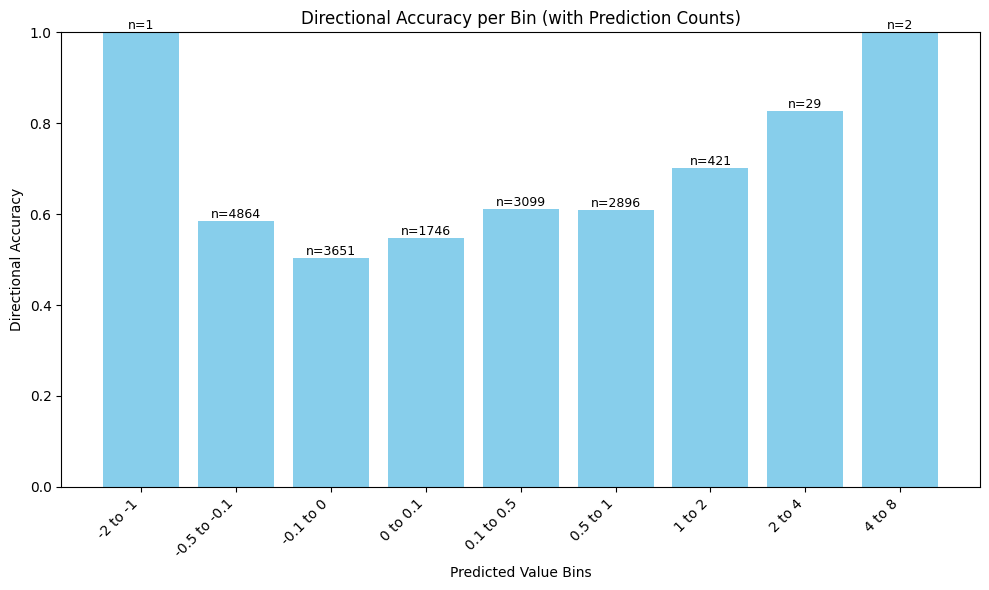

({'-2 to -1': np.float64(1.0),
  '-0.5 to -0.1': np.float64(0.5851151315789473),
  '-0.1 to 0': np.float64(0.5034237195288962),
  '0 to 0.1': np.float64(0.5481099656357389),
  '0.1 to 0.5': np.float64(0.6101968376895773),
  '0.5 to 1': np.float64(0.6094613259668509),
  '1 to 2': np.float64(0.7007125890736342),
  '2 to 4': np.float64(0.8275862068965517),
  '4 to 8': np.float64(1.0)},
 {'-2 to -1': np.int64(1),
  '-0.5 to -0.1': np.int64(4864),
  '-0.1 to 0': np.int64(3651),
  '0 to 0.1': np.int64(1746),
  '0.1 to 0.5': np.int64(3099),
  '0.5 to 1': np.int64(2896),
  '1 to 2': np.int64(421),
  '2 to 4': np.int64(29),
  '4 to 8': np.int64(2)})

In [ ]:
bins = [-np.inf, -8, -4, -2, -1, -0.5, -0.1, 0, 0.1, 0.5, 1, 2, 4, 8, np.inf]
plot_directional_accuracy(y_pred_actual, y_test_actual, bins=bins)